In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

# Creating dataset

In [3]:
folder_path = os.path.join(os.getcwd(), "Images")
folder_path

'/home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/Images'

In [3]:
# Remove corrupted images
num_skipped = 0
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for race in os.listdir(fpath):
        img = os.path.join(fpath, race)
        try:
            fobj = open(img, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(img)

print("Deleted %d images" % num_skipped)

Deleted 0 images


# Image pipeline

In [4]:
input_shape=(32, 180, 180, 3)
split=0.2
train_ds = keras.preprocessing.image_dataset_from_directory(
    folder_path,
    label_mode='categorical',
    image_size=input_shape[1:3],
    validation_split=split,
    subset="training",
    seed=42
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    folder_path,
    label_mode='categorical',
    image_size=input_shape[1:3],
    validation_split=split,
    subset="validation",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)

train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)


Found 20570 files belonging to 120 classes.
Using 16456 files for training.


2022-04-21 10:31:08.055841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:31:08.096980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:31:08.097093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:31:08.102248: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 20570 files belonging to 120 classes.
Using 4114 files for validation.


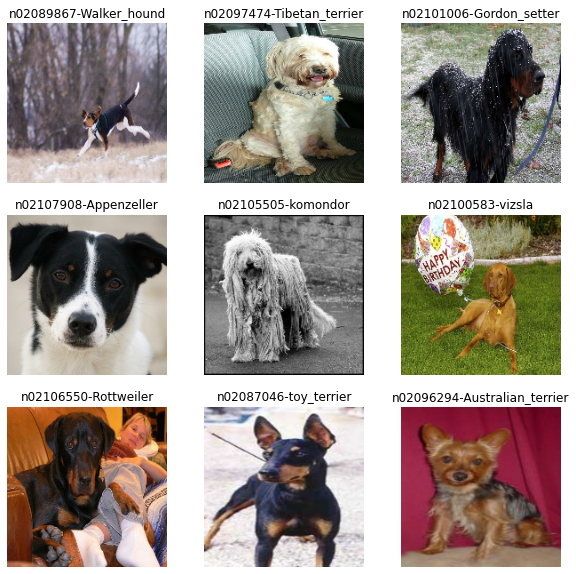

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10), facecolor='white')
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.2)
    ]
)


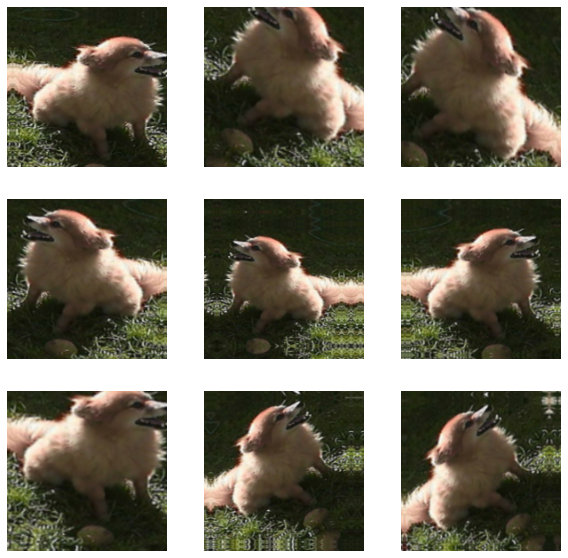

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
def plot_acc(history, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), facecolor='white')
    fig.suptitle(title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    
    plt.show()

# Building the model

## Naive approach

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

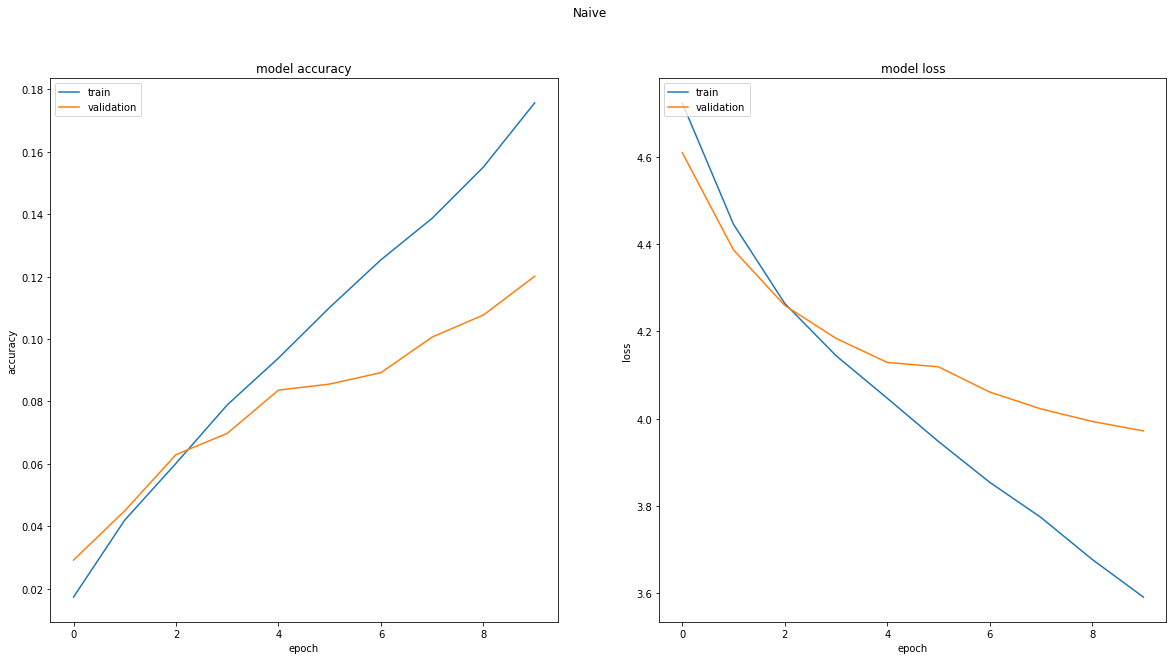

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=input_shape[1:]),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

plot_acc(history.history, 'Naive')

## VGG

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 128)       73856     
                                                             

2022-04-06 08:37:42.505568: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-04-06 08:37:43.560128: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


515/515 [==============================] - 39s 70ms/step - loss: 4.7461 - accuracy: 0.0152 - val_loss: 4.6290 - val_accuracy: 0.0226
Epoch 2/20
515/515 [==============================] - 35s 68ms/step - loss: 4.5475 - accuracy: 0.0285 - val_loss: 4.5129 - val_accuracy: 0.0355
Epoch 3/20
515/515 [==============================] - 35s 69ms/step - loss: 4.4399 - accuracy: 0.0388 - val_loss: 4.4099 - val_accuracy: 0.0438
Epoch 4/20
515/515 [==============================] - 35s 68ms/step - loss: 4.3049 - accuracy: 0.0546 - val_loss: 4.3034 - val_accuracy: 0.0537
Epoch 5/20
515/515 [==============================] - 35s 68ms/step - loss: 4.1854 - accuracy: 0.0688 - val_loss: 4.2479 - val_accuracy: 0.0605
Epoch 6/20
515/515 [==============================] - 35s 68ms/step - loss: 4.0918 - accuracy: 0.0814 - val_loss: 4.1996 - val_accuracy: 0.0676
Epoch 7/20
515/515 [==============================] - 35s 68ms/step - loss: 4.0064 - accuracy: 0.0924 - val_loss: 4.1304 - val_accuracy: 0.0756
Epo

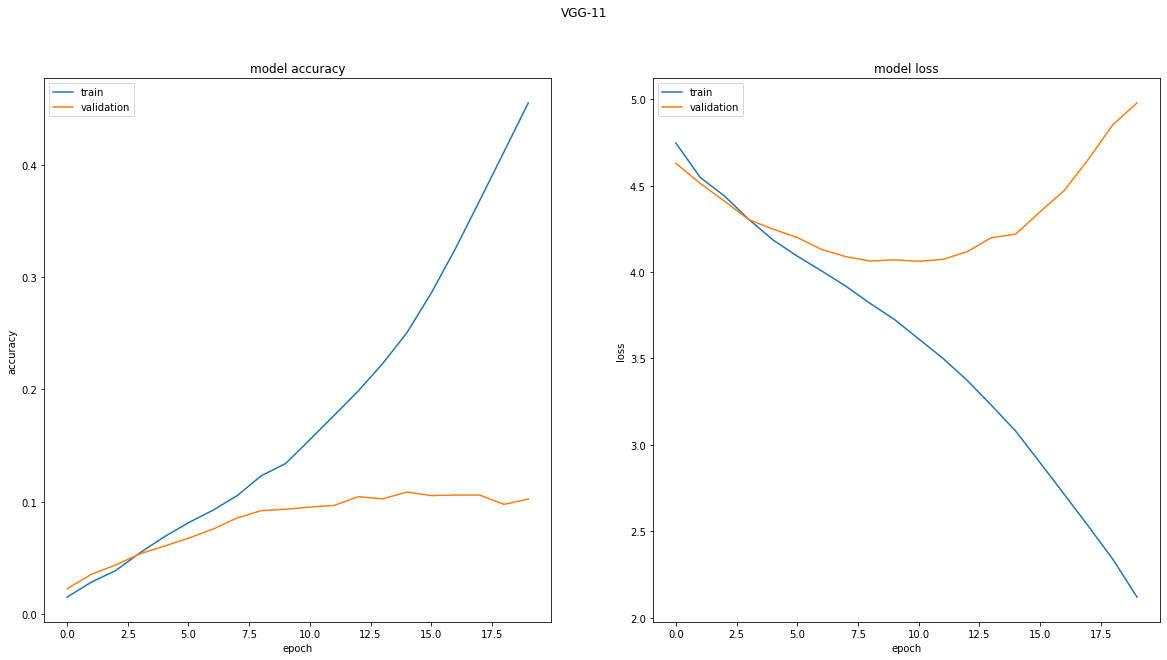

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 128)       73856     
                                                           

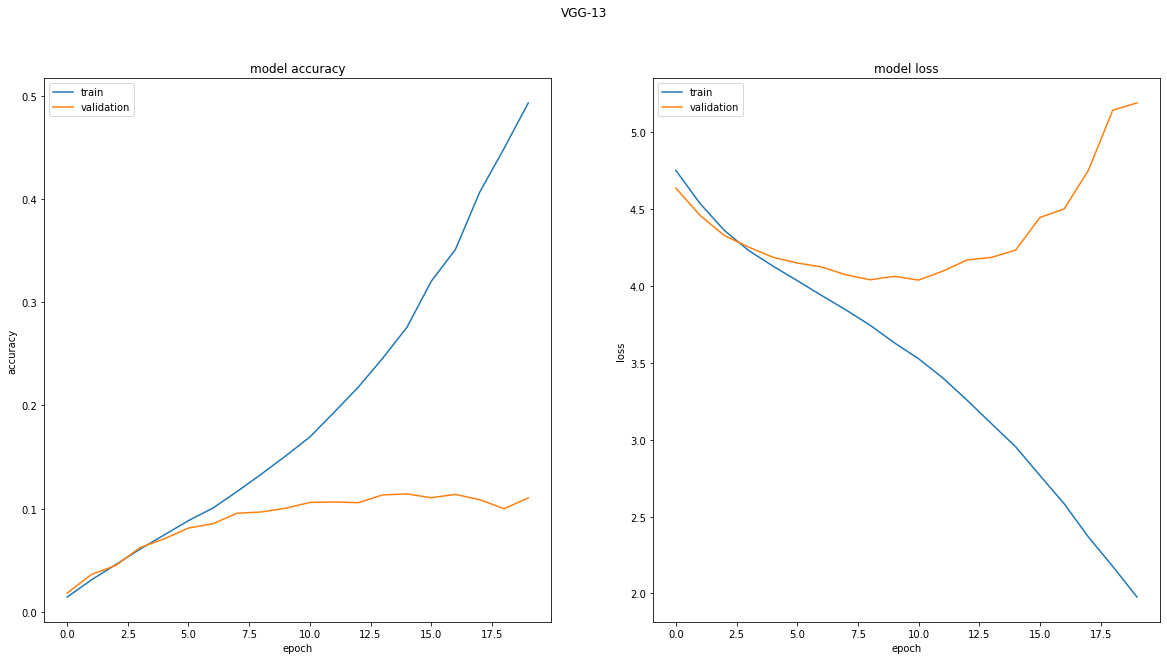

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 128)       73856     
                                                           

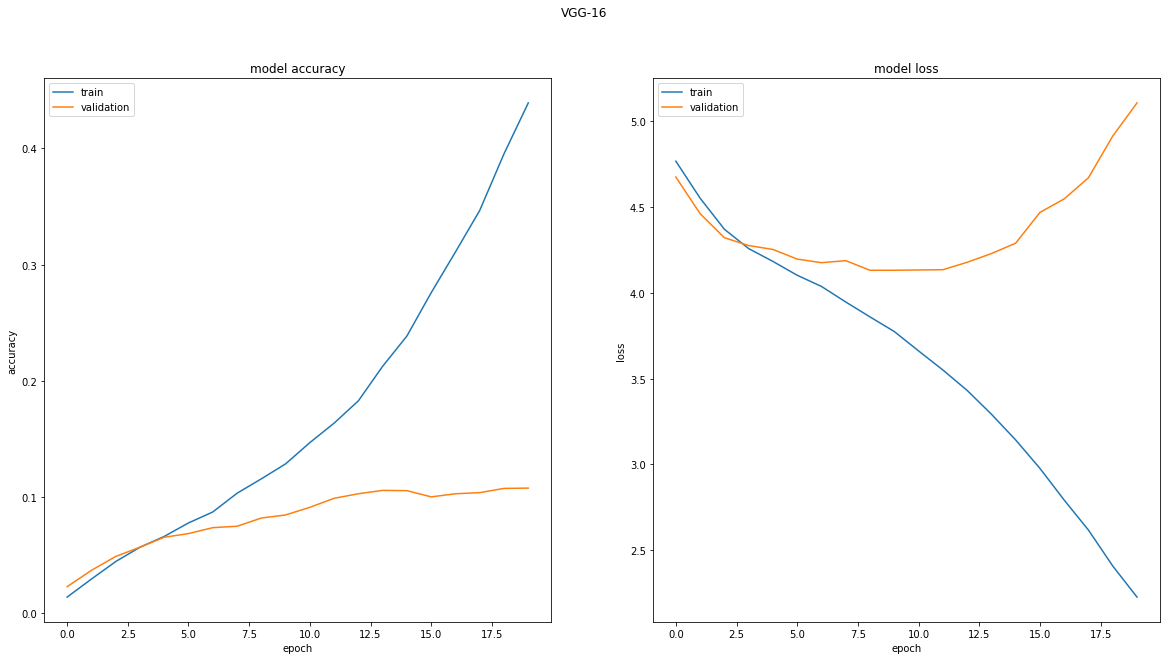

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 90, 90, 128)       73856     
                                                           

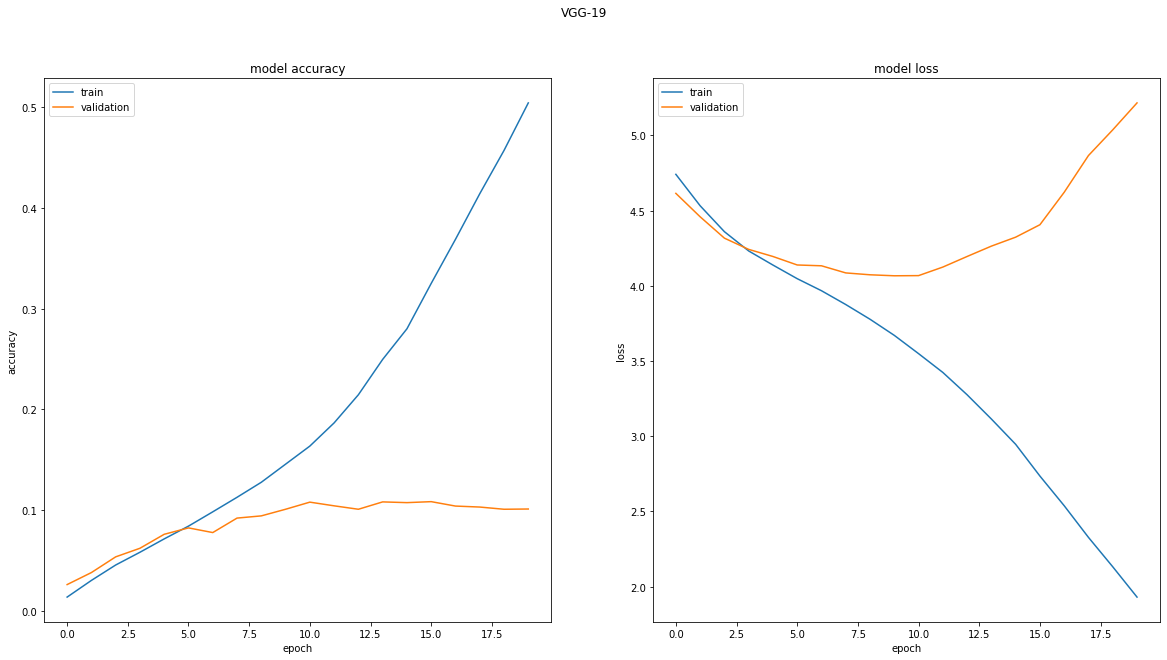

In [7]:
def make_vgg(num_layers=11):
    inputs = layers.Input(shape=input_shape[1:])
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    if num_layers >= 13:
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    if num_layers >= 13:
        x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    if num_layers >= 16:
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    if num_layers >= 19:
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 16:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 19:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 16:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 19:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(1000, activation='relu')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, f'VGG-{layers}')

epochs=20
architectures = [11, 13, 16, 19]

for arch in architectures:
    tf.keras.backend.clear_session()
    model = make_vgg()
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(
      train_ds,
      validation_data=test_ds,
      epochs=epochs
    )
    plot_acc(history.history, f'VGG-{arch}')


## ResNet

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']         

 batch_normalization_7 (BatchNo  (None, 23, 23, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 12, 512)  131584      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 12, 12, 512)  0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 activatio

2022-04-07 09:55:33.539420: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-04-07 09:55:34.490055: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-07 09:55:34.490296: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-07 09:55:34.490309: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-07 09:55:34.490506: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-07 09:55:34.490532: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-07 09:55:34.966571: I tensorflow/stream_executor/cuda/c

515/515 [==============================] - 85s 147ms/step - loss: 4.7966 - accuracy: 0.0219 - val_loss: 4.7133 - val_accuracy: 0.0236
Epoch 2/50
515/515 [==============================] - 63s 123ms/step - loss: 4.3406 - accuracy: 0.0469 - val_loss: 4.8889 - val_accuracy: 0.0462
Epoch 3/50
515/515 [==============================] - 64s 124ms/step - loss: 4.0648 - accuracy: 0.0681 - val_loss: 4.2833 - val_accuracy: 0.0554
Epoch 4/50
515/515 [==============================] - 64s 124ms/step - loss: 3.8151 - accuracy: 0.1034 - val_loss: 4.1333 - val_accuracy: 0.0839
Epoch 5/50
515/515 [==============================] - 64s 124ms/step - loss: 3.6053 - accuracy: 0.1342 - val_loss: 3.7595 - val_accuracy: 0.1291
Epoch 6/50
515/515 [==============================] - 64s 124ms/step - loss: 3.3831 - accuracy: 0.1649 - val_loss: 4.0255 - val_accuracy: 0.1026
Epoch 7/50
515/515 [==============================] - 64s 125ms/step - loss: 3.2161 - accuracy: 0.1983 - val_loss: 3.9437 - val_accuracy: 0.1

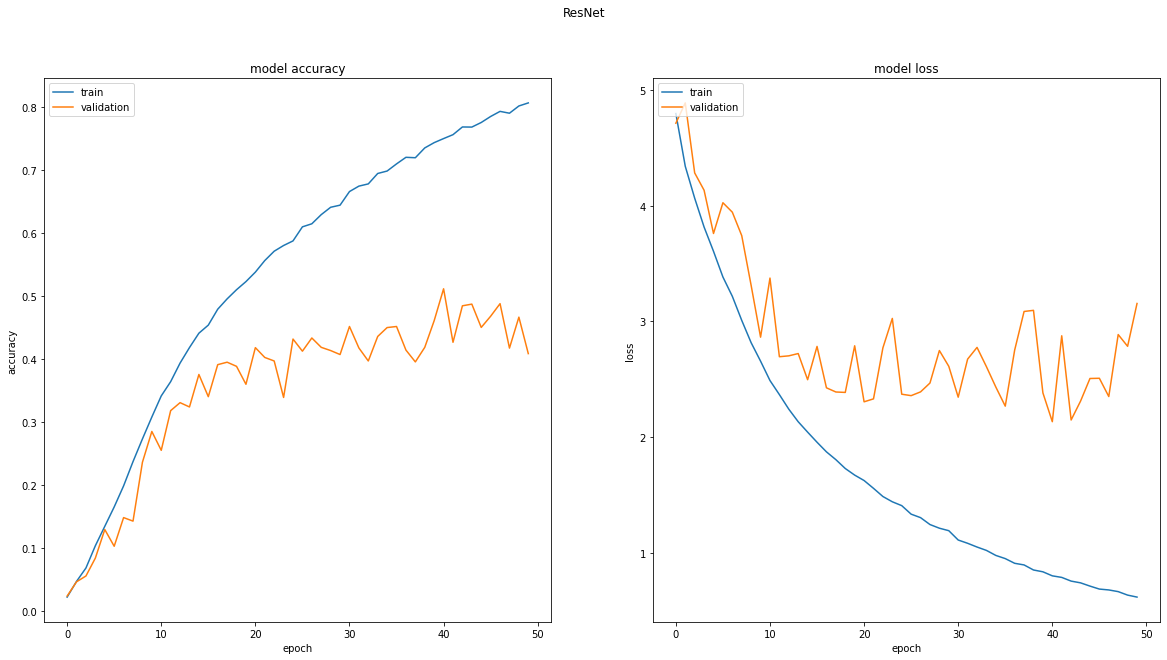

In [12]:
inputs = keras.Input(shape=input_shape[1:])
# Image augmentation block
x = data_augmentation(inputs)

# Entry block
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet')
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
epochs=50
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)
plot_acc(history.history, f'ResNet')

## Xception

In [33]:
def conv_bn(x, filters, kernel_size, strides=1):
    '''Creating Conv-BatchNorm block'''
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    '''Creating separableConv-BatchNorm block'''
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [31]:
def entry_flow(x):
    '''entry flow'''
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    x = ReLU()(x)
    previous_block_activation = x 

    x = sep_bn(x, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    previous_block_activation = conv_bn(previous_block_activation, filters=128, kernel_size = 1,strides=2)
    x = Add()([previous_block_activation,x])

    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    previous_block_activation = conv_bn(previous_block_activation, filters=256, kernel_size = 1,strides=2)
    x = Add()([previous_block_activation,x])

    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    previous_block_activation = conv_bn(previous_block_activation, filters=728, kernel_size = 1,strides=2)
    x = Add()([previous_block_activation,x])
    return x

def middle_flow(tensor):
    '''Middle flow'''
    previous_block_activation = tensor
    for _ in range(8):
        x = ReLU()(previous_block_activation)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        previous_block_activation = Add()([previous_block_activation,x])
        
    return previous_block_activation

def exit_flow(tensor):
    '''Exit flow'''
    previous_block_activation = tensor
    x = ReLU()(previous_block_activation)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    previous_block_activation = conv_bn(previous_block_activation, filters =1024, kernel_size=1, strides =2)
    x = Add()([previous_block_activation,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = num_classes, activation = 'softmax')(x)
    
    return x

In [34]:
inputs = Input(shape = input_shape[1:])
x = entry_flow(inputs)
x = middle_flow(x)
outputs = exit_flow(x)

model = Model(inputs=inputs, outputs=outputs, name='Xception')
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-5),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)
plot_acc(history.history, 'Xception')

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 90, 90, 32)   864         ['input_26[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 90, 90, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                           

 conv2d_8 (Conv2D)              (None, 12, 12, 728)  186368      ['batch_normalization_11[0][0]'] 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 23, 23, 728)  2912       ['separable_conv2d_5[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 12, 12, 728)  2912       ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 12, 12, 728)  0          ['batch_normalization_13[0][0]'] 
                                                                                                  
 add_14 (A

                                                                                                  
 batch_normalization_22 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_13[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 separable_conv2d_14 (Separable  (None, 12, 12, 728)  536536     ['re_lu_17[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_23 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_14[0][0]']    
 ormalizat

 re_lu_28 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_30[0][0]'] 
                                                                                                  
 separable_conv2d_22 (Separable  (None, 12, 12, 728)  536536     ['re_lu_28[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_31 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_22[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_29 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 separable

                                                                                                  
 batch_normalization_39 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_30[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_40 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 separable_conv2d_31 (Separable  (None, 12, 12, 1024  752024     ['re_lu_40[0][0]']               
 Conv2D)                        )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 6, 6, 1024)   745472      ['add_22[0][0]']                 
          

2022-04-07 21:20:22.619649: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-07 21:20:22.619672: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-07 21:20:22.625807: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-07 21:20:22.625821: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

 11/515 [..............................] - ETA: 1:31 - loss: 4.8049 - accuracy: 0.0000e+00

KeyboardInterrupt: 

# Transfer learning

## Top level training

Transfering to VGG-16
--------------------------------------------------------------------------------
Epoch 1/30
515/515 [==============================] - 28s 54ms/step - loss: 3.3280 - accuracy: 0.2047 - Top1 accuracy: 0.2047 - Top2 accuracy: 0.3200 - Top3 accuracy: 0.3987 - Top4 accuracy: 0.4584 - Top5 accuracy: 0.5036 - val_loss: 2.4957 - val_accuracy: 0.3432 - val_Top1 accuracy: 0.3432 - val_Top2 accuracy: 0.4915 - val_Top3 accuracy: 0.5965 - val_Top4 accuracy: 0.6587 - val_Top5 accuracy: 0.7117
Epoch 2/30
515/515 [==============================] - 27s 53ms/step - loss: 2.3235 - accuracy: 0.3792 - Top1 accuracy: 0.3792 - Top2 accuracy: 0.5460 - Top3 accuracy: 0.6426 - Top4 accuracy: 0.7055 - Top5 accuracy: 0.7485 - val_loss: 2.1960 - val_accuracy: 0.4115 - val_Top1 accuracy: 0.4115 - val_Top2 accuracy: 0.5875 - val_Top3 accuracy: 0.6801 - val_Top4 accuracy: 0.7368 - val_Top5 accuracy: 0.7693
Epoch 3/30
515/515 [==============================] - 27s 53ms/step - loss: 2.0578 - accu

Epoch 21/30
515/515 [==============================] - 27s 53ms/step - loss: 1.2087 - accuracy: 0.6669 - Top1 accuracy: 0.6669 - Top2 accuracy: 0.8013 - Top3 accuracy: 0.8562 - Top4 accuracy: 0.8869 - Top5 accuracy: 0.9048 - val_loss: 2.0386 - val_accuracy: 0.5360 - val_Top1 accuracy: 0.5360 - val_Top2 accuracy: 0.6745 - val_Top3 accuracy: 0.7377 - val_Top4 accuracy: 0.7766 - val_Top5 accuracy: 0.8053
Epoch 22/30
515/515 [==============================] - 27s 53ms/step - loss: 1.1835 - accuracy: 0.6760 - Top1 accuracy: 0.6760 - Top2 accuracy: 0.8061 - Top3 accuracy: 0.8591 - Top4 accuracy: 0.8872 - Top5 accuracy: 0.9053 - val_loss: 2.0991 - val_accuracy: 0.5430 - val_Top1 accuracy: 0.5430 - val_Top2 accuracy: 0.6692 - val_Top3 accuracy: 0.7321 - val_Top4 accuracy: 0.7759 - val_Top5 accuracy: 0.8048
Epoch 23/30
515/515 [==============================] - 27s 53ms/step - loss: 1.1489 - accuracy: 0.6848 - Top1 accuracy: 0.6848 - Top2 accuracy: 0.8127 - Top3 accuracy: 0.8660 - Top4 accuracy

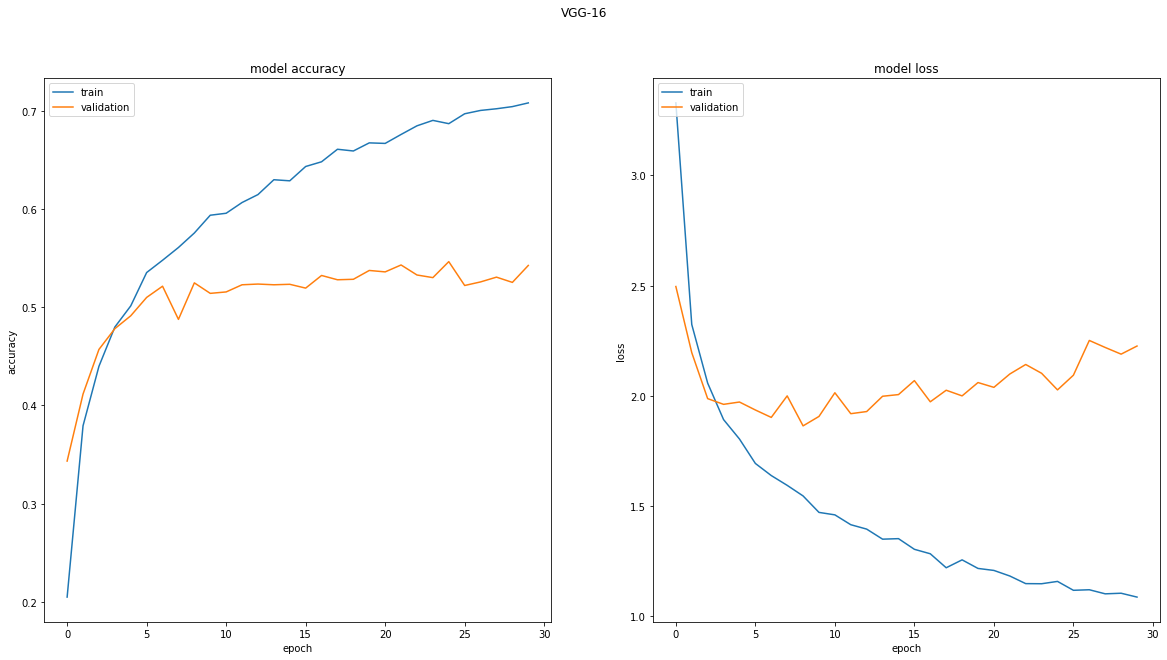

Transfering to VGG-19
--------------------------------------------------------------------------------
Epoch 1/30
515/515 [==============================] - 32s 61ms/step - loss: 3.3011 - accuracy: 0.2169 - Top1 accuracy: 0.2169 - Top2 accuracy: 0.3309 - Top3 accuracy: 0.4056 - Top4 accuracy: 0.4630 - Top5 accuracy: 0.5058 - val_loss: 2.4328 - val_accuracy: 0.3687 - val_Top1 accuracy: 0.3687 - val_Top2 accuracy: 0.5211 - val_Top3 accuracy: 0.6074 - val_Top4 accuracy: 0.6665 - val_Top5 accuracy: 0.7151
Epoch 2/30
515/515 [==============================] - 31s 61ms/step - loss: 2.2901 - accuracy: 0.3876 - Top1 accuracy: 0.3876 - Top2 accuracy: 0.5558 - Top3 accuracy: 0.6500 - Top4 accuracy: 0.7103 - Top5 accuracy: 0.7513 - val_loss: 2.1694 - val_accuracy: 0.4210 - val_Top1 accuracy: 0.4210 - val_Top2 accuracy: 0.5931 - val_Top3 accuracy: 0.6855 - val_Top4 accuracy: 0.7363 - val_Top5 accuracy: 0.7752
Epoch 3/30
515/515 [==============================] - 31s 61ms/step - loss: 2.0361 - accu

Epoch 21/30
515/515 [==============================] - 31s 61ms/step - loss: 1.2465 - accuracy: 0.6655 - Top1 accuracy: 0.6655 - Top2 accuracy: 0.7935 - Top3 accuracy: 0.8471 - Top4 accuracy: 0.8774 - Top5 accuracy: 0.8982 - val_loss: 2.1031 - val_accuracy: 0.5386 - val_Top1 accuracy: 0.5386 - val_Top2 accuracy: 0.6646 - val_Top3 accuracy: 0.7268 - val_Top4 accuracy: 0.7710 - val_Top5 accuracy: 0.7992
Epoch 22/30
515/515 [==============================] - 31s 61ms/step - loss: 1.2108 - accuracy: 0.6714 - Top1 accuracy: 0.6714 - Top2 accuracy: 0.7995 - Top3 accuracy: 0.8568 - Top4 accuracy: 0.8845 - Top5 accuracy: 0.9026 - val_loss: 2.0864 - val_accuracy: 0.5367 - val_Top1 accuracy: 0.5367 - val_Top2 accuracy: 0.6723 - val_Top3 accuracy: 0.7368 - val_Top4 accuracy: 0.7761 - val_Top5 accuracy: 0.8009
Epoch 23/30
515/515 [==============================] - 31s 61ms/step - loss: 1.1487 - accuracy: 0.6858 - Top1 accuracy: 0.6858 - Top2 accuracy: 0.8115 - Top3 accuracy: 0.8662 - Top4 accuracy

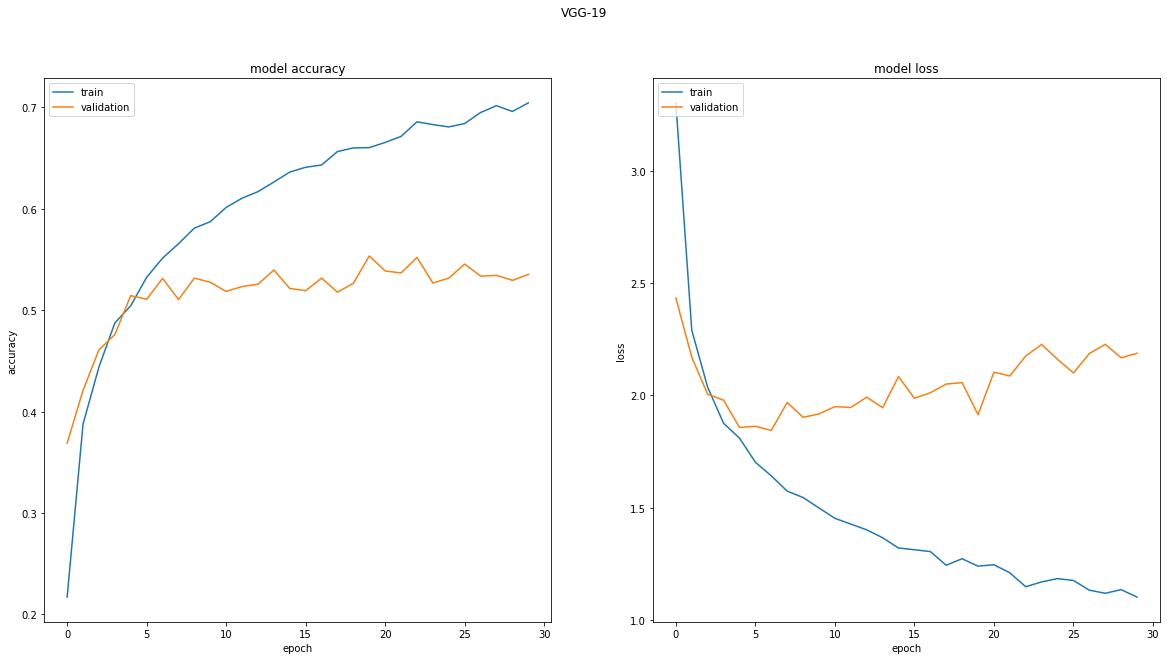

Transfering to ResNetV2
--------------------------------------------------------------------------------
Epoch 1/30
515/515 [==============================] - 21s 38ms/step - loss: 3.1220 - accuracy: 0.2409 - Top1 accuracy: 0.2409 - Top2 accuracy: 0.3692 - Top3 accuracy: 0.4468 - Top4 accuracy: 0.5046 - Top5 accuracy: 0.5482 - val_loss: 2.2543 - val_accuracy: 0.3989 - val_Top1 accuracy: 0.3989 - val_Top2 accuracy: 0.5729 - val_Top3 accuracy: 0.6687 - val_Top4 accuracy: 0.7219 - val_Top5 accuracy: 0.7608
Epoch 2/30
515/515 [==============================] - 19s 37ms/step - loss: 2.2138 - accuracy: 0.4105 - Top1 accuracy: 0.4105 - Top2 accuracy: 0.5772 - Top3 accuracy: 0.6680 - Top4 accuracy: 0.7237 - Top5 accuracy: 0.7623 - val_loss: 2.1395 - val_accuracy: 0.4368 - val_Top1 accuracy: 0.4368 - val_Top2 accuracy: 0.6033 - val_Top3 accuracy: 0.6830 - val_Top4 accuracy: 0.7270 - val_Top5 accuracy: 0.7606
Epoch 3/30
515/515 [==============================] - 19s 37ms/step - loss: 1.9989 - ac

Epoch 21/30
515/515 [==============================] - 19s 37ms/step - loss: 1.3100 - accuracy: 0.6564 - Top1 accuracy: 0.6564 - Top2 accuracy: 0.7772 - Top3 accuracy: 0.8304 - Top4 accuracy: 0.8605 - Top5 accuracy: 0.8802 - val_loss: 1.9631 - val_accuracy: 0.5430 - val_Top1 accuracy: 0.5430 - val_Top2 accuracy: 0.6694 - val_Top3 accuracy: 0.7302 - val_Top4 accuracy: 0.7703 - val_Top5 accuracy: 0.7931
Epoch 22/30
515/515 [==============================] - 19s 37ms/step - loss: 1.2997 - accuracy: 0.6560 - Top1 accuracy: 0.6560 - Top2 accuracy: 0.7837 - Top3 accuracy: 0.8325 - Top4 accuracy: 0.8614 - Top5 accuracy: 0.8822 - val_loss: 2.0106 - val_accuracy: 0.5423 - val_Top1 accuracy: 0.5423 - val_Top2 accuracy: 0.6599 - val_Top3 accuracy: 0.7214 - val_Top4 accuracy: 0.7647 - val_Top5 accuracy: 0.7931
Epoch 23/30
515/515 [==============================] - 19s 37ms/step - loss: 1.2998 - accuracy: 0.6593 - Top1 accuracy: 0.6593 - Top2 accuracy: 0.7830 - Top3 accuracy: 0.8355 - Top4 accuracy

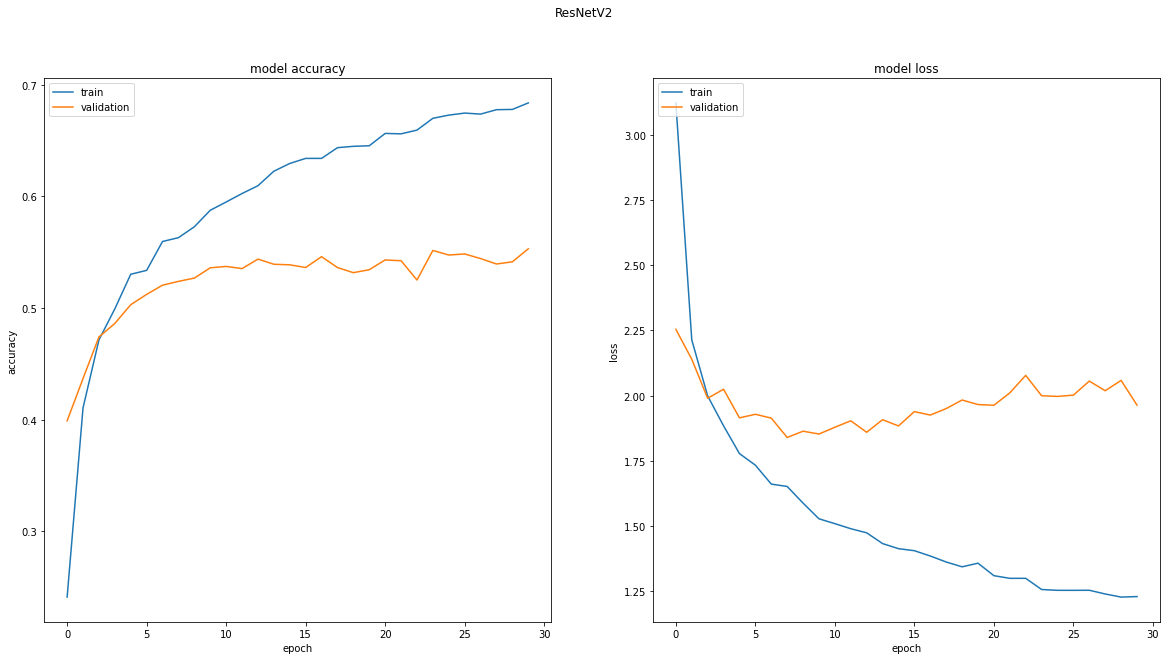

Transfering to Xception
--------------------------------------------------------------------------------
Epoch 1/30
515/515 [==============================] - 24s 44ms/step - loss: 2.6908 - accuracy: 0.3483 - Top1 accuracy: 0.3483 - Top2 accuracy: 0.4863 - Top3 accuracy: 0.5639 - Top4 accuracy: 0.6168 - Top5 accuracy: 0.6500 - val_loss: 1.8455 - val_accuracy: 0.5175 - val_Top1 accuracy: 0.5175 - val_Top2 accuracy: 0.6753 - val_Top3 accuracy: 0.7443 - val_Top4 accuracy: 0.7800 - val_Top5 accuracy: 0.8058
Epoch 2/30
515/515 [==============================] - 22s 43ms/step - loss: 1.8772 - accuracy: 0.5144 - Top1 accuracy: 0.5144 - Top2 accuracy: 0.6688 - Top3 accuracy: 0.7443 - Top4 accuracy: 0.7837 - Top5 accuracy: 0.8097 - val_loss: 1.7915 - val_accuracy: 0.5486 - val_Top1 accuracy: 0.5486 - val_Top2 accuracy: 0.6869 - val_Top3 accuracy: 0.7518 - val_Top4 accuracy: 0.7902 - val_Top5 accuracy: 0.8143
Epoch 3/30
515/515 [==============================] - 22s 42ms/step - loss: 1.7033 - ac

Epoch 21/30
515/515 [==============================] - 22s 43ms/step - loss: 1.1539 - accuracy: 0.7030 - Top1 accuracy: 0.7030 - Top2 accuracy: 0.8162 - Top3 accuracy: 0.8613 - Top4 accuracy: 0.8845 - Top5 accuracy: 0.9006 - val_loss: 1.6826 - val_accuracy: 0.6140 - val_Top1 accuracy: 0.6140 - val_Top2 accuracy: 0.7299 - val_Top3 accuracy: 0.7834 - val_Top4 accuracy: 0.8158 - val_Top5 accuracy: 0.8371
Epoch 22/30
515/515 [==============================] - 22s 43ms/step - loss: 1.1611 - accuracy: 0.6982 - Top1 accuracy: 0.6982 - Top2 accuracy: 0.8105 - Top3 accuracy: 0.8570 - Top4 accuracy: 0.8817 - Top5 accuracy: 0.8993 - val_loss: 1.6946 - val_accuracy: 0.6009 - val_Top1 accuracy: 0.6009 - val_Top2 accuracy: 0.7256 - val_Top3 accuracy: 0.7761 - val_Top4 accuracy: 0.8075 - val_Top5 accuracy: 0.8333
Epoch 23/30
515/515 [==============================] - 22s 42ms/step - loss: 1.1628 - accuracy: 0.6989 - Top1 accuracy: 0.6989 - Top2 accuracy: 0.8113 - Top3 accuracy: 0.8580 - Top4 accuracy

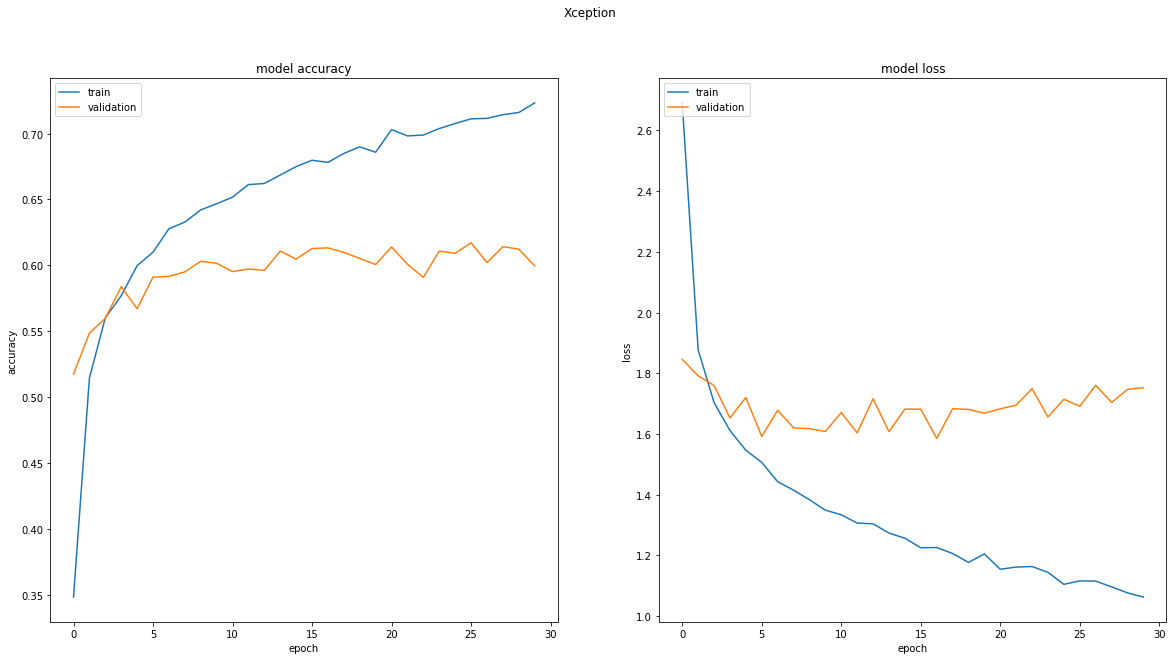

Transfering to InceptionV3
--------------------------------------------------------------------------------
Epoch 1/30
515/515 [==============================] - 19s 33ms/step - loss: 3.0018 - accuracy: 0.2752 - Top1 accuracy: 0.2752 - Top2 accuracy: 0.4025 - Top3 accuracy: 0.4814 - Top4 accuracy: 0.5345 - Top5 accuracy: 0.5709 - val_loss: 2.1678 - val_accuracy: 0.4125 - val_Top1 accuracy: 0.4125 - val_Top2 accuracy: 0.5802 - val_Top3 accuracy: 0.6728 - val_Top4 accuracy: 0.7333 - val_Top5 accuracy: 0.7654
Epoch 2/30
515/515 [==============================] - 16s 30ms/step - loss: 2.0370 - accuracy: 0.4643 - Top1 accuracy: 0.4643 - Top2 accuracy: 0.6297 - Top3 accuracy: 0.7164 - Top4 accuracy: 0.7603 - Top5 accuracy: 0.7890 - val_loss: 1.8160 - val_accuracy: 0.5090 - val_Top1 accuracy: 0.5090 - val_Top2 accuracy: 0.6677 - val_Top3 accuracy: 0.7499 - val_Top4 accuracy: 0.7934 - val_Top5 accuracy: 0.8230
Epoch 3/30
515/515 [==============================] - 16s 30ms/step - loss: 1.8485 -

Epoch 21/30
515/515 [==============================] - 16s 31ms/step - loss: 1.4160 - accuracy: 0.6330 - Top1 accuracy: 0.6330 - Top2 accuracy: 0.7596 - Top3 accuracy: 0.8134 - Top4 accuracy: 0.8447 - Top5 accuracy: 0.8669 - val_loss: 1.7206 - val_accuracy: 0.5851 - val_Top1 accuracy: 0.5851 - val_Top2 accuracy: 0.7163 - val_Top3 accuracy: 0.7773 - val_Top4 accuracy: 0.8104 - val_Top5 accuracy: 0.8345
Epoch 22/30
515/515 [==============================] - 16s 31ms/step - loss: 1.3981 - accuracy: 0.6328 - Top1 accuracy: 0.6328 - Top2 accuracy: 0.7584 - Top3 accuracy: 0.8158 - Top4 accuracy: 0.8474 - Top5 accuracy: 0.8680 - val_loss: 1.6760 - val_accuracy: 0.5875 - val_Top1 accuracy: 0.5875 - val_Top2 accuracy: 0.7183 - val_Top3 accuracy: 0.7766 - val_Top4 accuracy: 0.8065 - val_Top5 accuracy: 0.8318
Epoch 23/30
515/515 [==============================] - 16s 31ms/step - loss: 1.3981 - accuracy: 0.6373 - Top1 accuracy: 0.6373 - Top2 accuracy: 0.7641 - Top3 accuracy: 0.8191 - Top4 accuracy

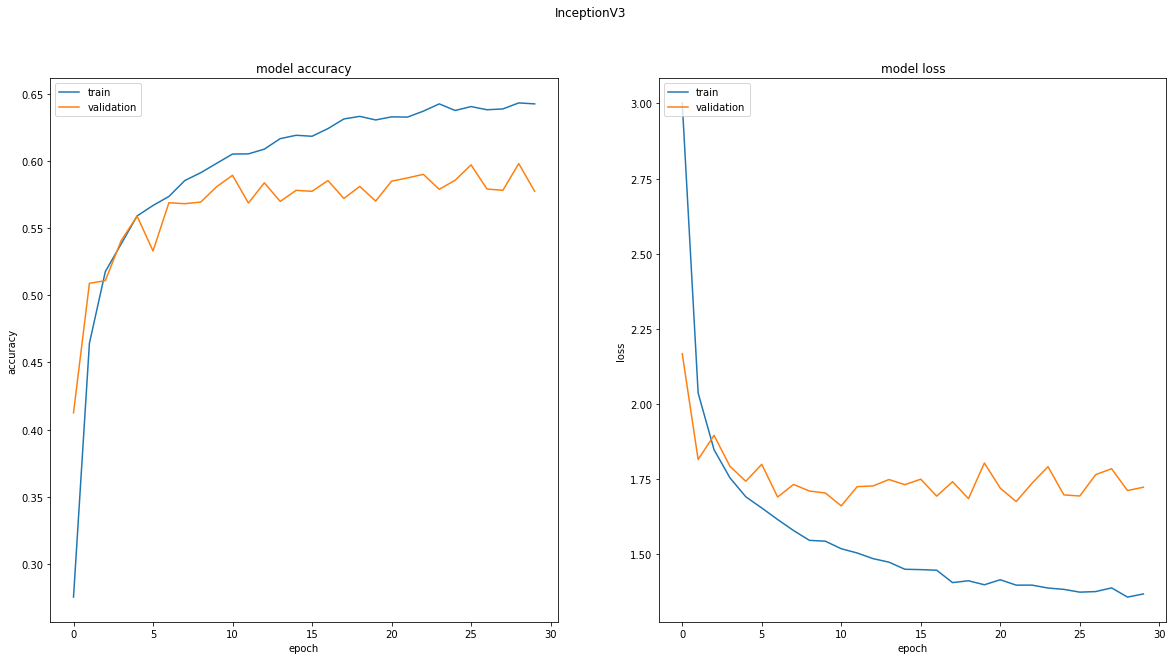

In [9]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

epochs=30
base_models = [
    ('VGG-16', keras.applications.vgg16.VGG16, keras.applications.vgg16.preprocess_input),
    ('VGG-19', keras.applications.vgg19.VGG19, keras.applications.vgg19.preprocess_input),
    ('ResNetV2', keras.applications.resnet_v2.ResNet50V2, keras.applications.resnet_v2.preprocess_input),
    ('Xception', keras.applications.xception.Xception, keras.applications.xception.preprocess_input),
    ('InceptionV3', keras.applications.inception_v3.InceptionV3, keras.applications.inception_v3.preprocess_input)
]

trained_models = []
for name, model, preprocess in base_models:
    print(f'Transfering to {name}')
    print('-'*80)
    base_model = model(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=input_shape[1:],
        include_top=False)

    base_model.trainable = False

    inputs = keras.Input(shape=input_shape[1:])
    x = data_augmentation(inputs, training=True)
    x = preprocess(x)
    x = base_model(x, training=False)
    #x = keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    #model.summary()
    metrics = ['accuracy']
    for i in range(1, 6):
        metrics.append(TopKCategoricalAccuracy(i, f'Top{i} accuracy'))
        
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=metrics)
    
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, min_delta=0.0001, restore_best_weights=True)
    history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)#, callbacks=[es])
    trained_models.append((base_model, model))
    plot_acc(history.history, name)
    print('=' * 80)

## Fine tuning

In [ ]:
for base_model, model in trained_models:
    base_model.trainable = True
    #model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss='categorical_crossentropy',
        metrics=metrics,
    )

    epochs = 20
    history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)
    plot_acc(history.history, model.name)

Epoch 1/20


2022-04-21 14:39:25.494077: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-21 14:39:25.494099: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


515/515 [==============================] - 64s 121ms/step - loss: 1.0354 - accuracy: 0.7174 - Top1 accuracy: 0.6894 - Top2 accuracy: 0.8074 - Top3 accuracy: 0.8577 - Top4 accuracy: 0.8842 - Top5 accuracy: 0.9012 - val_loss: 1.9148 - val_accuracy: 0.5717 - val_Top1 accuracy: 0.5717 - val_Top2 accuracy: 0.7005 - val_Top3 accuracy: 0.7657 - val_Top4 accuracy: 0.8019 - val_Top5 accuracy: 0.8243
Epoch 2/20
515/515 [==============================] - 62s 120ms/step - loss: 0.9370 - accuracy: 0.7447 - Top1 accuracy: 0.7447 - Top2 accuracy: 0.8543 - Top3 accuracy: 0.8969 - Top4 accuracy: 0.9184 - Top5 accuracy: 0.9321 - val_loss: 1.9602 - val_accuracy: 0.5671 - val_Top1 accuracy: 0.5671 - val_Top2 accuracy: 0.7018 - val_Top3 accuracy: 0.7659 - val_Top4 accuracy: 0.8007 - val_Top5 accuracy: 0.8209
Epoch 3/20
515/515 [==============================] - 62s 120ms/step - loss: 0.8551 - accuracy: 0.7600 - Top1 accuracy: 0.7600 - Top2 accuracy: 0.8659 - Top3 accuracy: 0.9092 - Top4 accuracy: 0.9299 - 

In [12]:
for _, model in trained_models:
    model.save(os.path.join(os.getcwd(), model.name))

2022-04-20 18:13:58.522862: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/VGG-16/assets
INFO:tensorflow:Assets written to: /home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/VGG-19/assets
INFO:tensorflow:Assets written to: /home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/ResNetV2/assets
INFO:tensorflow:Assets written to: /home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/Xception/assets
INFO:tensorflow:Assets written to: /home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/InceptionV3/assets


Epoch 1/20


2022-04-21 10:31:36.444230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-21 10:31:37.388121: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-21 10:31:37.388295: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-21 10:31:37.388308: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-21 10:31:37.388488: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-21 10:31:37.388513: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-21 10:31:37.762161: W tensorflow/core/common_runtime/bf

515/515 [==============================] - 112s 196ms/step - loss: 1.1313 - accuracy: 0.6895 - top_k_categorical_accuracy: 0.9081 - val_loss: 1.5212 - val_accuracy: 0.6169 - val_top_k_categorical_accuracy: 0.8636
Epoch 2/20
515/515 [==============================] - 96s 186ms/step - loss: 1.0968 - accuracy: 0.6941 - top_k_categorical_accuracy: 0.9174 - val_loss: 1.4855 - val_accuracy: 0.6303 - val_top_k_categorical_accuracy: 0.8627
Epoch 3/20
515/515 [==============================] - 94s 183ms/step - loss: 1.0105 - accuracy: 0.7148 - top_k_categorical_accuracy: 0.9265 - val_loss: 1.4241 - val_accuracy: 0.6393 - val_top_k_categorical_accuracy: 0.8792
Epoch 4/20
515/515 [==============================] - 94s 183ms/step - loss: 0.9077 - accuracy: 0.7423 - top_k_categorical_accuracy: 0.9375 - val_loss: 1.3938 - val_accuracy: 0.6546 - val_top_k_categorical_accuracy: 0.8814
Epoch 5/20
515/515 [==============================] - 96s 187ms/step - loss: 0.8838 - accuracy: 0.7487 - top_k_categor

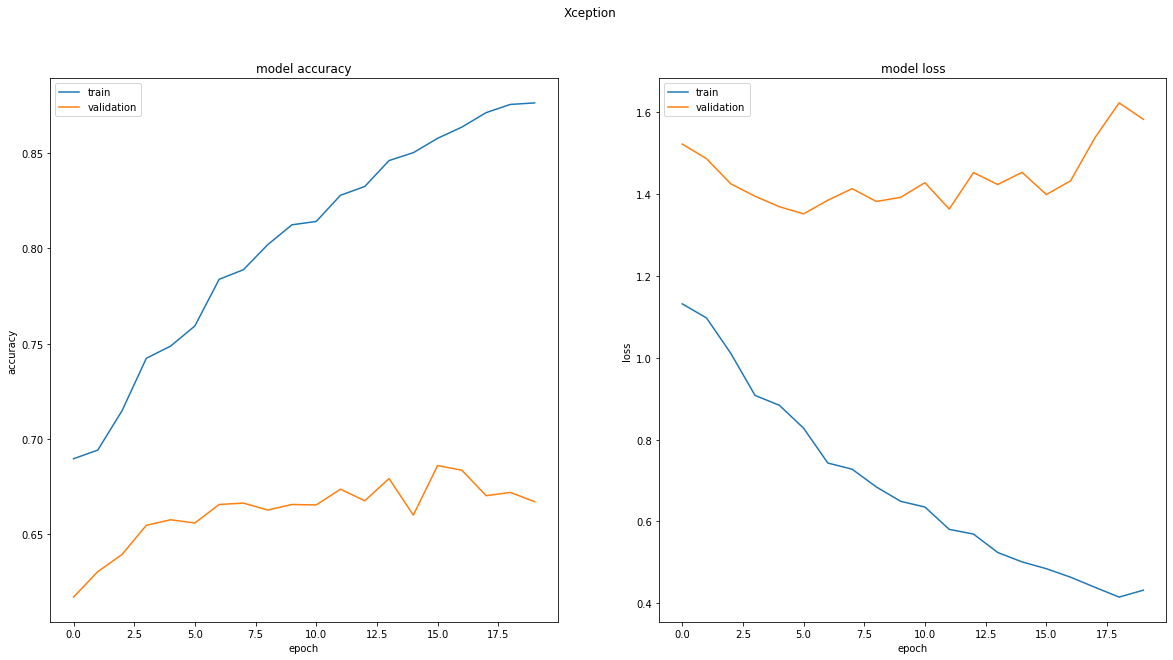

In [7]:
loaded = keras.models.load_model(os.path.join(os.getcwd(), 'Xception'))
loaded.trainable = True
metrics = ['accuracy', 'top_k_categorical_accuracy']
loaded.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=metrics,
)

epochs = 20
history = loaded.fit(train_ds, epochs=epochs, validation_data=test_ds)
plot_acc(history.history, loaded.name)

# Test

In [ ]:
img = keras.preprocessing.image.load_img(
    "jerome.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

top4 = predictions.argsort()[0, -1:-5:-1]

for race, acc in zip(np.array(race_names)[top4], predictions[0, top4]):
    print(f'{race} at {acc:.2%}')